In [2]:
%load_ext autoreload
%autoreload 2

Make `conceptlab` importable (in the future we will have this will not be necessary once we've cast this into a package)

In [3]:
import sys
SRC_DIR = '../'
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

Import

In [4]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Initial Example

Generate an example dataset, we specify some arbitrary values for the different covariates

In [5]:
n_obs = 5000
n_vars = 1000

n_tissues = 3
n_celltypes = 10
n_batches = 2
n_concepts = 8

For the data generation we will use the `generate` function from our `DataGenerator` class, you have the function definition below

### Intervention example

Generate Original Data

In [244]:
dataset = clab.datagen.omics.OmicsDataGenerator.generate(n_obs = 1000,
                                                         n_vars = 100, 
                                                         n_tissues=n_tissues,
                                                         n_celltypes=n_celltypes,
                                                         n_batches = n_batches,
                                                         n_concepts = n_concepts,
                                                         std_concept= 0.5,
                                                         seed=42,
                                                         beta_a = 1,
                                                         beta_b = 0.5,
                                                        )
                                                         

Get the concepts from the original data, we will use this to introduce a pertubation

In [245]:
new_concepts = dataset.concepts.to_numpy().copy()

Pick concept to perturb

In [246]:
pert_concept = 3

Introduce intervention/perturbation - in this case we activate the concept in _all_ cells

In [247]:
new_concepts[:,pert_concept] = 1 

Visualize the old concepts (50 example cells) vs. the new ones

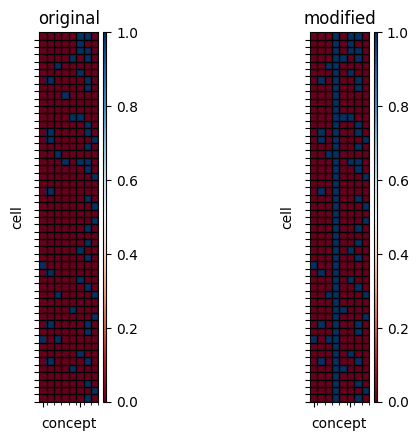

In [248]:
fig,ax = plt.subplots(1,2)
clab.datagen.plot.matrix_plot(dataset.concepts.to_numpy()[0:50,:], xlabel='concept', ylabel = 'cell', ax=ax[0],show =False)
clab.datagen.plot.matrix_plot(new_concepts[0:50,:], xlabel='concept', ylabel = 'cell', ax=ax[1],show = False)
ax[0].set_title('original')
ax[1].set_title('perturbed')
plt.show()

Use the `generate_intervention` method from the Generator class. This takes an old dataset, and the new concepts (all other covariates are kept the same). The result will be the perturbed gene expression for the _same_ cells as in the original data but with the new concepts (remember this is a probabilistic model).

In [249]:
new_data = clab.datagen.omics.OmicsDataGenerator.generate_intervention(dataset, new_concepts)

Get the old (original) gene expression data from the dataset object.

In [251]:
old_data = dataset.data.to_dataframe().unstack()['data'].copy()

Grab the concept coefficients - this is a `n_concept x n_gene` matrix which tells you how much each each gene is influenced by the different concepts.
<br><br>
A positive coefficient means that the gene is more highly expressed in the cells with the concept active and a negative coefficient means the opposite. This is agreement with the idea if up-and downregulation of genes.

In [252]:
coefs = dataset.concept_coef.to_dataframe().unstack()['concept_coef']

We get the names of the genes with positive and negative coefficient values for the concept we perturbed

In [253]:
pos_concept_vars = coefs.columns[(coefs.iloc[pert_concept,:] > 0).values].tolist()
neg_concept_vars = coefs.columns[(coefs.iloc[pert_concept,:] < 0).values].tolist()

Next, we compute the average gene expression across the pos/neg concept genes in every cell in the original and perturbed data.

In [261]:
results = dict(values = [], data= [], coef_direction = [])
for data_name,data in zip(['perturbed','original'],[new_data,old_data]):
    for direction_name,genes in zip(['up','down'],[pos_concept_vars,neg_concept_vars]):
        ndata = data.loc[:,genes].copy()
        ndata = ndata.mean(axis=1).values
        results['values'] += ndata.tolist()
        results['data'] += len(ndata) * [data_name]
        results['coef_direction'] += len(ndata) * [direction_name]

results = pd.DataFrame(results)
# for visualization
results['data'] = pd.Categorical(results['data'], ['original','perturbed'])

In [258]:
import matplotlib.pyplot as plt

Visualize the results

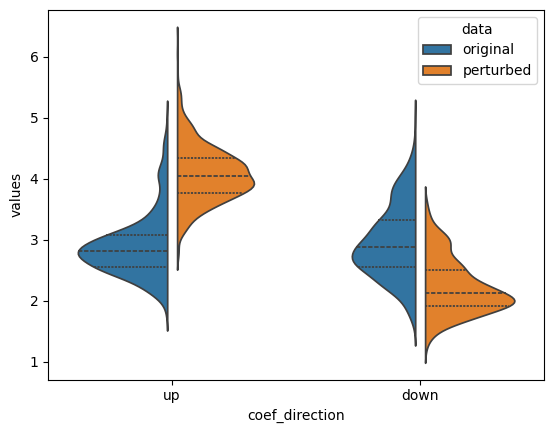

In [262]:
sns.violinplot(results, y = 'values', x = 'coef_direction', hue = 'data', split=True, gap=.1, inner="quart")
plt.show()

The gene expression of the genes with positive coefficients (up) are more highly expressed in the perturbed case while the gene expression is lower for the genes with negative coefficients (down). This is exactly what we expect.